In [1]:
from flim_processing import (
    FlimParams,
    StreamReceiver,
    DataManager,
    PhasorComputer,
    FittingEngine,
    SeriesMetadata,
    ElementData,
    EndSeries
)


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import time
%matplotlib inline
plt.rcParams['figure.figsize'] = (14, 5)

In [3]:
UDP_PORT = 4444
UDP_ADDR = "127.0.0.1"

In [8]:
# Create a stream receiver
receiver = StreamReceiver(port=UDP_PORT, addr=UDP_ADDR)
print(f"StreamReceiver created and ready to receive data")
print(f"Listening on port {UDP_PORT}")

StreamReceiver created and ready to receive data
Listening on port 4444


In [9]:
period = 12.5  # nanoseconds (80 MHz laser)
time_bins = 256

flim_params = FlimParams(
    period=period,
    fit_start=10,
    fit_end=200
)

In [10]:
# Initialize variables for data processinga
data_manager = None
frame_count = 0
max_frames = 10  # Process up to 10 frames for this example

# Storage for results
phasor_results = []
lifetime_results = []

print("Starting to receive data...")
print("(Press Ctrl+C to stop)\n")

try:
    for event in receiver.start_receiving():
        if isinstance(event, SeriesMetadata):
            # New series started
            print(f"\n=== New Series {event.series_no} ===")
            print(f"Shape: {event.shape}")
            print(f"Data type: {event.dtype}")
            
            # Initialize data manager for this series
            data_manager = DataManager(
                shape=event.shape,
                dtype=event.dtype,
                delta_mode=False
            )
            frame_count = 0
            
        elif isinstance(event, ElementData):
            # New frame received
            frame_count += 1
            print(f"Frame {frame_count}: seqno={event.seqno}, shape={event.frame.shape}")
            
            # Add to data manager
            data_manager.add_element(event.seqno, event.frame)
            
            # Process the frame
            photon_count = event.frame
            
            # Compute phasor
            phasor = PhasorComputer.compute_phasor(photon_count, flim_params)
            phasor_results.append(phasor)
            
            # Compute lifetime (RLD)
            rld_result = FittingEngine.compute_rld(photon_count, flim_params)
            lifetime_results.append(rld_result.tau)
            
            print(f"  Phasor: g=[{np.nanmin(phasor[..., 0]):.3f}, {np.nanmax(phasor[..., 0]):.3f}], "
                  f"s=[{np.nanmin(phasor[..., 1]):.3f}, {np.nanmax(phasor[..., 1]):.3f}]")
            print(f"  Lifetime: [{np.nanmin(rld_result.tau):.3f}, {np.nanmax(rld_result.tau):.3f}] ns")
            
            # Create snapshot every few frames
            if frame_count % 3 == 0:
                data_manager.snapshot()
                print(f"  Created snapshot (total snapshots: {data_manager.get_frame_count() - 1})")
            
            # Stop after max_frames
            if frame_count >= max_frames:
                print(f"\nReached {max_frames} frames, stopping...")
                break
                
        elif isinstance(event, EndSeries):
            # Series ended
            print(f"\n=== Series {event.series_no} Ended ===")
            break
            
except KeyboardInterrupt:
    print("\nReceiving interrupted by user")
finally:
    receiver.stop_receiving()
    print("Receiver stopped")

print(f"\nProcessed {frame_count} frames")

Starting to receive data...
(Press Ctrl+C to stop)


=== New Series 0 ===
Shape: (256, 256, 256)
Data type: uint16
Frame 1: seqno=0, shape=(256, 256, 256)
  Phasor: g=[-1.000, 1.000], s=[-1.000, 1.000]
  Lifetime: [nan, nan] ns


C:\Users\lociuser\AppData\Local\Temp\ipykernel_2544\144404457.py:50: RuntimeWarning: All-NaN slice encountered
  print(f"  Lifetime: [{np.nanmin(rld_result.tau):.3f}, {np.nanmax(rld_result.tau):.3f}] ns")


Frame 2: seqno=1, shape=(256, 256, 256)
  Phasor: g=[-1.000, 1.000], s=[-1.000, 1.000]
  Lifetime: [nan, nan] ns
Frame 3: seqno=2, shape=(256, 256, 256)
  Phasor: g=[-1.000, 1.000], s=[-1.000, 1.000]
  Lifetime: [nan, nan] ns
  Created snapshot (total snapshots: 0)
Frame 4: seqno=3, shape=(256, 256, 256)
  Phasor: g=[-1.000, 1.000], s=[-1.000, 1.000]
  Lifetime: [nan, nan] ns
Frame 5: seqno=4, shape=(256, 256, 256)
  Phasor: g=[-1.000, 1.000], s=[-1.000, 1.000]
  Lifetime: [nan, nan] ns
Frame 6: seqno=5, shape=(256, 256, 256)
  Phasor: g=[-1.000, 1.000], s=[-1.000, 1.000]
  Lifetime: [nan, nan] ns
  Created snapshot (total snapshots: 1)

=== Series 0 Ended ===
Receiver stopped

Processed 6 frames


## lifetime results

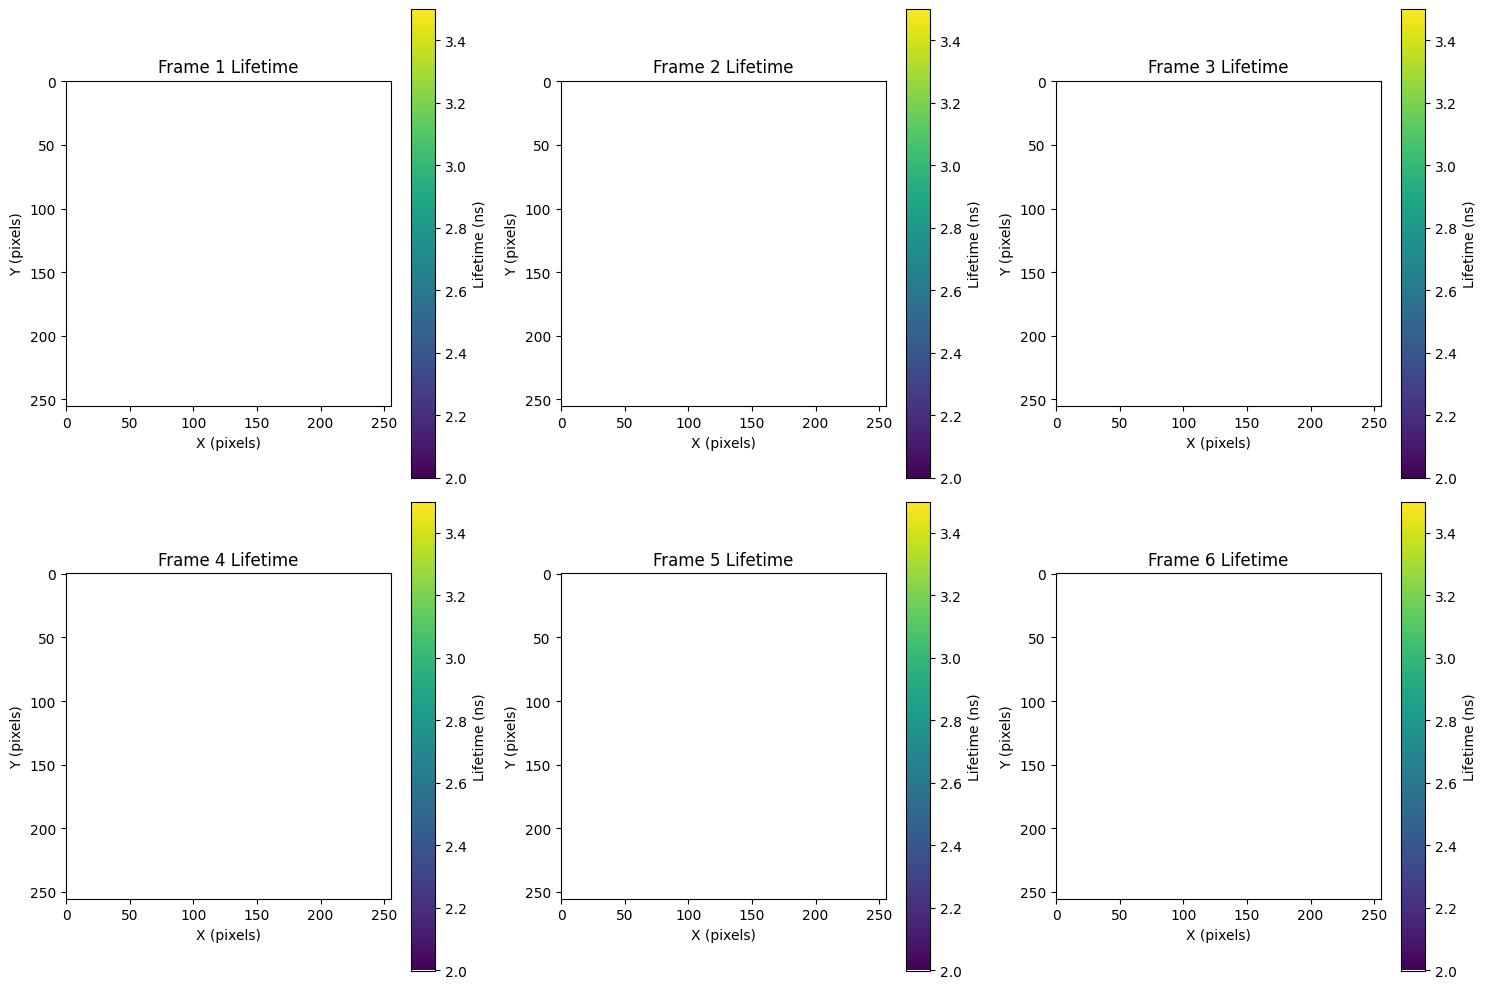

In [11]:
if len(lifetime_results) > 0:
    # Show lifetime evolution over frames
    n_frames = min(6, len(lifetime_results))
    fig, axes = plt.subplots(2, 3, figsize=(15, 10))
    axes = axes.flatten()
    
    for i in range(n_frames):
        im = axes[i].imshow(lifetime_results[i], cmap='viridis', vmin=2.0, vmax=3.5)
        axes[i].set_title(f'Frame {i+1} Lifetime', fontsize=12)
        axes[i].set_xlabel('X (pixels)')
        axes[i].set_ylabel('Y (pixels)')
        plt.colorbar(im, ax=axes[i], label='Lifetime (ns)')
    
    # Hide unused subplots
    for i in range(n_frames, 6):
        axes[i].axis('off')
    
    plt.tight_layout()
    plt.show()
else:
    print("No frames were processed. Make sure the data sender is running.")

In [15]:
data_manager.get_frame_count()

2

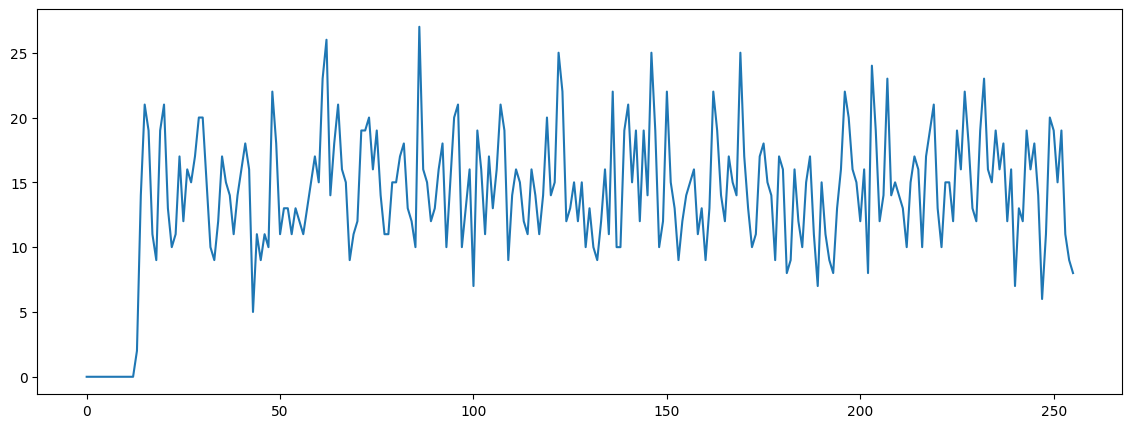

In [19]:
x = data_manager.get_photon_count(0)
plt.plot(x.sum((0,1)))

Total frames in DataManager: 2


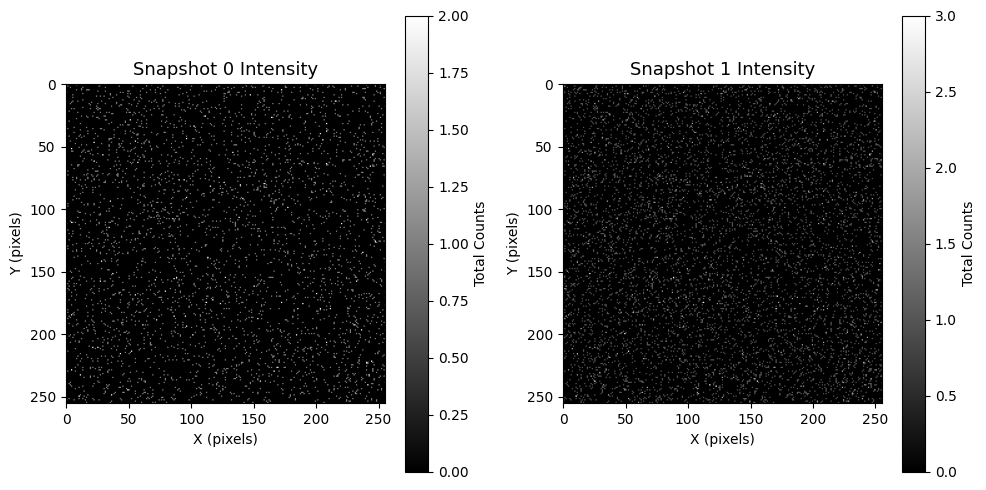

In [13]:
if data_manager is not None and data_manager.get_frame_count() > 1:
    print(f"Total frames in DataManager: {data_manager.get_frame_count()}")
    
    # Retrieve and compare snapshots
    n_snapshots = min(3, data_manager.get_frame_count())
    
    fig, axes = plt.subplots(1, n_snapshots, figsize=(5*n_snapshots, 5))
    if n_snapshots == 1:
        axes = [axes]
    
    for i in range(n_snapshots):
        # Get snapshot
        snapshot = data_manager.get_photon_count(i)
        
        # Compute intensity (sum over time)
        intensity = np.sum(snapshot, axis=-1)
        
        im = axes[i].imshow(intensity, cmap='gray')
        axes[i].set_title(f'Snapshot {i} Intensity', fontsize=13)
        axes[i].set_xlabel('X (pixels)')
        axes[i].set_ylabel('Y (pixels)')
        plt.colorbar(im, ax=axes[i], label='Total Counts')
    
    plt.tight_layout()
    plt.show()
else:
    print("No snapshots available.")